# Multi-objective Optimization wit BOAR

Version 0.1
(c) Larry Lueer, Vincent M. Le Corre, i-MEET 2021-2023

Fitting transient photoluminescence (TrPL) data and a time-resolved microwave conductivity (TrMC) at the same time

In [1]:
# Activate matplotlib widgets
%matplotlib inline
# comment the next line if you are on the jupyterhub server
%matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
# import one folder up
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings

# Import Experimental Data
In this section you need to write a function that imports the experimental data. The function should return two array X and y. X is a 2D array with the experimental data. Each row of X is a data point. y is a 1D array with the experimental results. Each row of y is a result vector for the corresponding data point in X.

For example, if you are trying to fit light-intensity dependent JV curves, then X is a 2D array (or list) with in the first column the applied voltage ('Vext') and in the second column the light intensity ('Gfrac') and y is a 1D array (or list) with the JV curves. If you have several light intensities, just append the data to X and y.

In [2]:
# Define the path to the data 
curr_dir = os.getcwd()
path2data  = os.path.join('/home/vlc/Desktop/Chris/Data','CsMAPbIBr')# path to the JV files, use this line if Notebook is in the Notebooks folder
filename = 'S15M2_L532_F0.csv' # filename of the PL and MC data

curr_dir = os.getcwd()
res_dir = os.path.join(curr_dir,'temp') # path to the results directory, use this line if Notebook is in the Notebooks folder
# res_dir = os.path.join('../','temp') # path to the results directory, use this line if Notebook is in the Notebooks folder




Text(0, 0.5, 'MC (a.u.)')

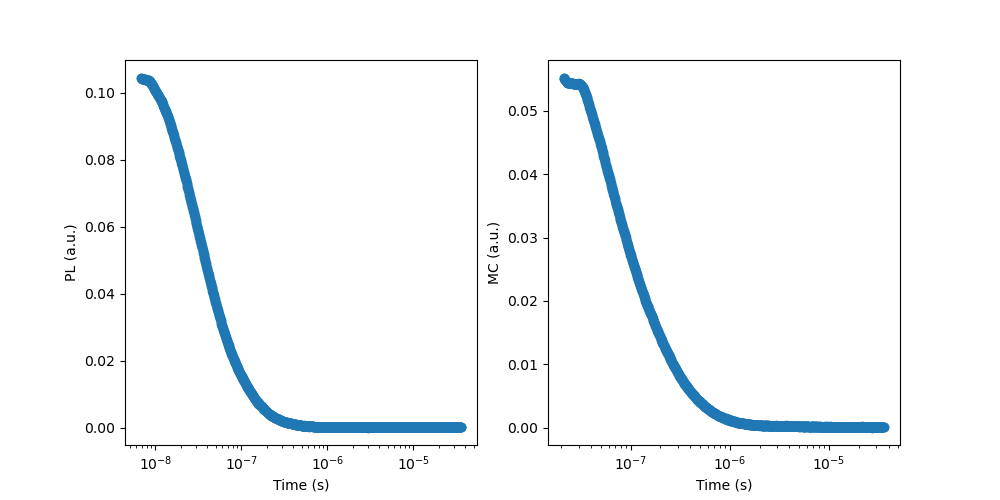

In [3]:
def get_trPL(path2data,filenames,Gfrac=1,num_pts=1e3,take_log=False):


    for filename in filenames:
        data=[[],[]]
        data_diode=[[],[]]
        #Load file and extract data
        with open(os.path.join(path2data,filename)) as f:
            for line in f:
                tmp=line.strip("\n").split(",")

                if len(tmp)>8:
                    data_diode[0].append(float(tmp[9]))
                    data_diode[1].append(float(tmp[10]))
                else:
                    raise ValueError("The file does not contain PL data")


        X,y = [],[]
        if len(tmp)>8:   
            for i in range(len(data_diode[0])):
                X.append([data_diode[0][i]])
                y.append(data_diode[1][i])
    
    X = np.array(X)
    y = np.array(y)
    # get mean value of the values before X[:,0] = 0
    index = np.where(X[:,0]<0)
    background = np.mean(y[index])
    y = y - background # subtract background
    
    # get index of the pick
    index = np.argmax(abs(y))
    # remove datapoints for index > index of the pick
    index = np.where(X[:,0]>X[index,0])
    X = X[index]
    y = abs(y[index])

    # interpolate to get num_pts
    X_interp = np.geomspace(X[1],X[-1],int(num_pts))

    # add 0 to the beginning of X_interp
    X_interp = np.insert(X_interp,0,0)
    y_interp = np.interp(X_interp,X[:,0],y)
    
    X,y = [],[]
    for i in range(len(X_interp)):
        X.append([X_interp[i],Gfrac])
        y.append(y_interp[i])

    X = np.array(X)
    y = np.array(y)

    if take_log:
        y = np.log10(y)

    return X,y

def get_trMC(path2data,filenames,Gfrac=1,num_pts=1e3,take_log=False):

    for filename in filenames:
        data=[[],[]]
        data_diode=[[],[]]
        #Load file and extract data
        with open(os.path.join(path2data,filename)) as f:
            for line in f:
                tmp=line.strip("\n").split(",")
                data[0].append(float(tmp[3]))
                data[1].append(float(tmp[4]))


        X,y = [],[]
        for i in range(len(data[0])):
            X.append([data[0][i]])
            y.append(data[1][i])
    
    X = np.array(X)
    y = np.array(y)

    # get mean value of the values before X[:,0] = 0
    index = np.where(X[:,0]<0)
    background = np.mean(y[index])
    y = y - background # subtract background
    
    # get index of the pick
    index_max = np.argmax(abs(y))
    # remove datapoints for index > index of the pick
    index = np.where(X[:,0]>X[index_max,0])
    X = X[index]
    y = y[index]

    # get the sign of the index_max
    sign = np.sign(y[index_max])
    y = sign*y

     # interpolate to get num_pts
    X_interp = np.geomspace(X[1],X[-1],int(num_pts))

    # add 0 to the beginning of X_interp
    X_interp = np.insert(X_interp,0,0)
    y_interp = np.interp(X_interp,X[:,0],y)
    
    X,y = [],[]
    for i in range(len(X_interp)):
        X.append([X_interp[i],Gfrac])
        y.append(y_interp[i])

    X = np.array(X)
    y = np.array(y)

    if take_log:
        y = np.log10(y)

    return X,y



# make plot with 2 subplots for PL and MC
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

X_PL,y_PL = get_trPL(path2data,[filename],take_log=False)
weight_PL = 1/(np.abs(y_PL))
X_MC,y_MC = get_trMC(path2data,[filename],take_log=False)
weight_MC = 1/(np.abs(y_MC))

# plot PL
ax1.semilogx(X_PL[:,0],y_PL,'o',label='PL')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('PL (a.u.)')

# plot MC
ax2.semilogx(X_MC[:,0],y_MC,'o',label='MC')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('MC (a.u.)')




In [4]:

# define Fitparameters
# create fit parameters for the various processes we have to consider in the model
True_values = {'kdirect': 3e-16, 'ktrap': 2e-19, 'kdetrap':1e-19,'Bulk_tr':1e22,'p_0':0e19, 'QE': 1, 'I_PL': 0.8e-31, 'N0': 6.511e22, 'r_mu':1, 'I_MC':8e-25}
params = []
kdirect = Fitparam(name = 'kdirect', val =  True_values['kdirect'], lims = [5e-17, 1e-15], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'k$_2$ [m$^{3}$ s$^{-1}$]')
params.append(kdirect)
ktrap = Fitparam(name = 'ktrap', val = True_values['ktrap'], lims = [1e-22, 1e-19] , relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'k$_{trap}$ [m$^{3}$ s$^{-1}$]')
params.append(ktrap)
kdetrap = Fitparam(name = 'kdetrap', val =  True_values['kdetrap'], lims = [1e-21, 1e-18], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'k$_{detrap}$ [m$^{3}$ s$^{-1}$]')
params.append(kdetrap)
Bulk_tr = Fitparam(name = 'Bulk_tr', val =  True_values['Bulk_tr'], lims = [1e19, 5e22], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'N$_T$ [m$^{-3}$]')
params.append(Bulk_tr)
p_0 = Fitparam(name = 'p_0', val =  True_values['p_0'], lims = [1e18, 5e21], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'p$_0$ [m$^{-3}$]')
params.append(p_0)
QE = Fitparam(name = 'QE', val =  True_values['QE'], lims = [0.02, 1], relRange = 0, range_type = 'linear',
            lim_type = 'absolute',optim_type = 'linear', display_name = 'QE [%]')
params.append(QE)
I_PL = Fitparam(name = 'I_PL', val =  True_values['I_PL'], lims = [1e-32, 1e-29], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'I$_{PL}$')
params.append(I_PL)
I_MC = Fitparam(name = 'I_MC', val =  True_values['I_MC'], lims = [1e-26, 1e-25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'I$_{MC}$')
params.append(I_MC)
r_mu = Fitparam(name = 'r_mu', val =  True_values['r_mu'], lims = [1e-1, 1e2], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type='log', display_name = 'r$_\mu$')
params.append(r_mu)
N0 = Fitparam(name = 'N0', val =  True_values['N0'], lims = [5e22, 7e22], relRange = 0, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'N$_0$ [m$^{-3}$]')
params.append(N0)


In [5]:
# Make fake data
rng = default_rng()
# noise = 1e4 # noise level
fpu = 1e3 # pump frequency in Hz
background = 0e24 # background pump density in m^-3


# create trPL agent
trPL = TrPL_agent(trPL_model = Bimolecular_Trapping_Detrapping_equation)
trPL.pump_params['fpu'] = fpu
trPL.pump_params['N0'] = 6.511e22
trPL.pump_params['background'] = background

# create trMC agent
trMC = TrMC_agent(trMC_model = Bimolecular_Trapping_Detrapping_equation)
trMC.pump_params['fpu'] = fpu
trMC.pump_params['N0'] = 6.511e22
trMC.pump_params['background'] = background


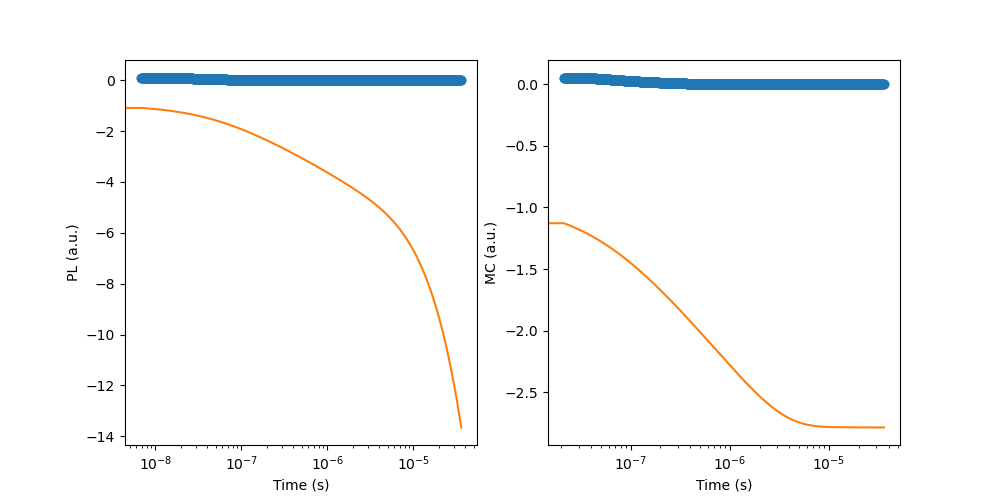

In [6]:
# test the model
X_dimensions = ['t','Gfrac']
y_PL_model = trPL.trPL(X_PL,params,X_dimensions=X_dimensions,take_log=True)
y_MC_model = trMC.trMC(X_MC,params,X_dimensions=X_dimensions,take_log=True)

# plot the model
fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.semilogx(X_PL[:,0],y_PL,'o',label='PL')
ax1.semilogx(X_PL[:,0],y_PL_model,'-',label='PL')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('PL (a.u.)')
# ax1.set_ylim([-6,0])

# plot MC
ax2.semilogx(X_MC[:,0],y_MC,'o',label='MC')
ax2.semilogx(X_MC[:,0],y_MC_model,'-',label='MC')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('MC (a.u.)')
# ax2.set_ylim([-6,0])

plt.show()


Scaling runs for target 0:   0%|          | 0/1 [00:00<?, ?it/s]

Scaling runs for target 1:   0%|          | 0/1 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/5 [00:00<?, ?it/s]

Initial points done in 86.65 s
Starting with BO


BO runs:   0%|          | 0/20 [00:00<?, ?it/s]

BO done in 724.17 s
Ground truth minimum at: [-15.566244978513044, -19.0, -20.763732642783406, 22.683954945382133, 21.69897000433602, -31.162015709615748, -25.85764475461451, 1.9832647054494656] with function value: 0.07569042879920823
Minimum of surrogate function: [-15.877513411207063, -19.0, -21.0, 22.69897000433602, 21.69897000433602, -30.34411532484891, -25.704562381434506, 1.6651755767039844] with function value 0.011613096302365733
Sampling for posterior distribution done in  37.48613619804382 s
Sampling for posterior distribution done in  37.48218870162964 s
2 zooms done


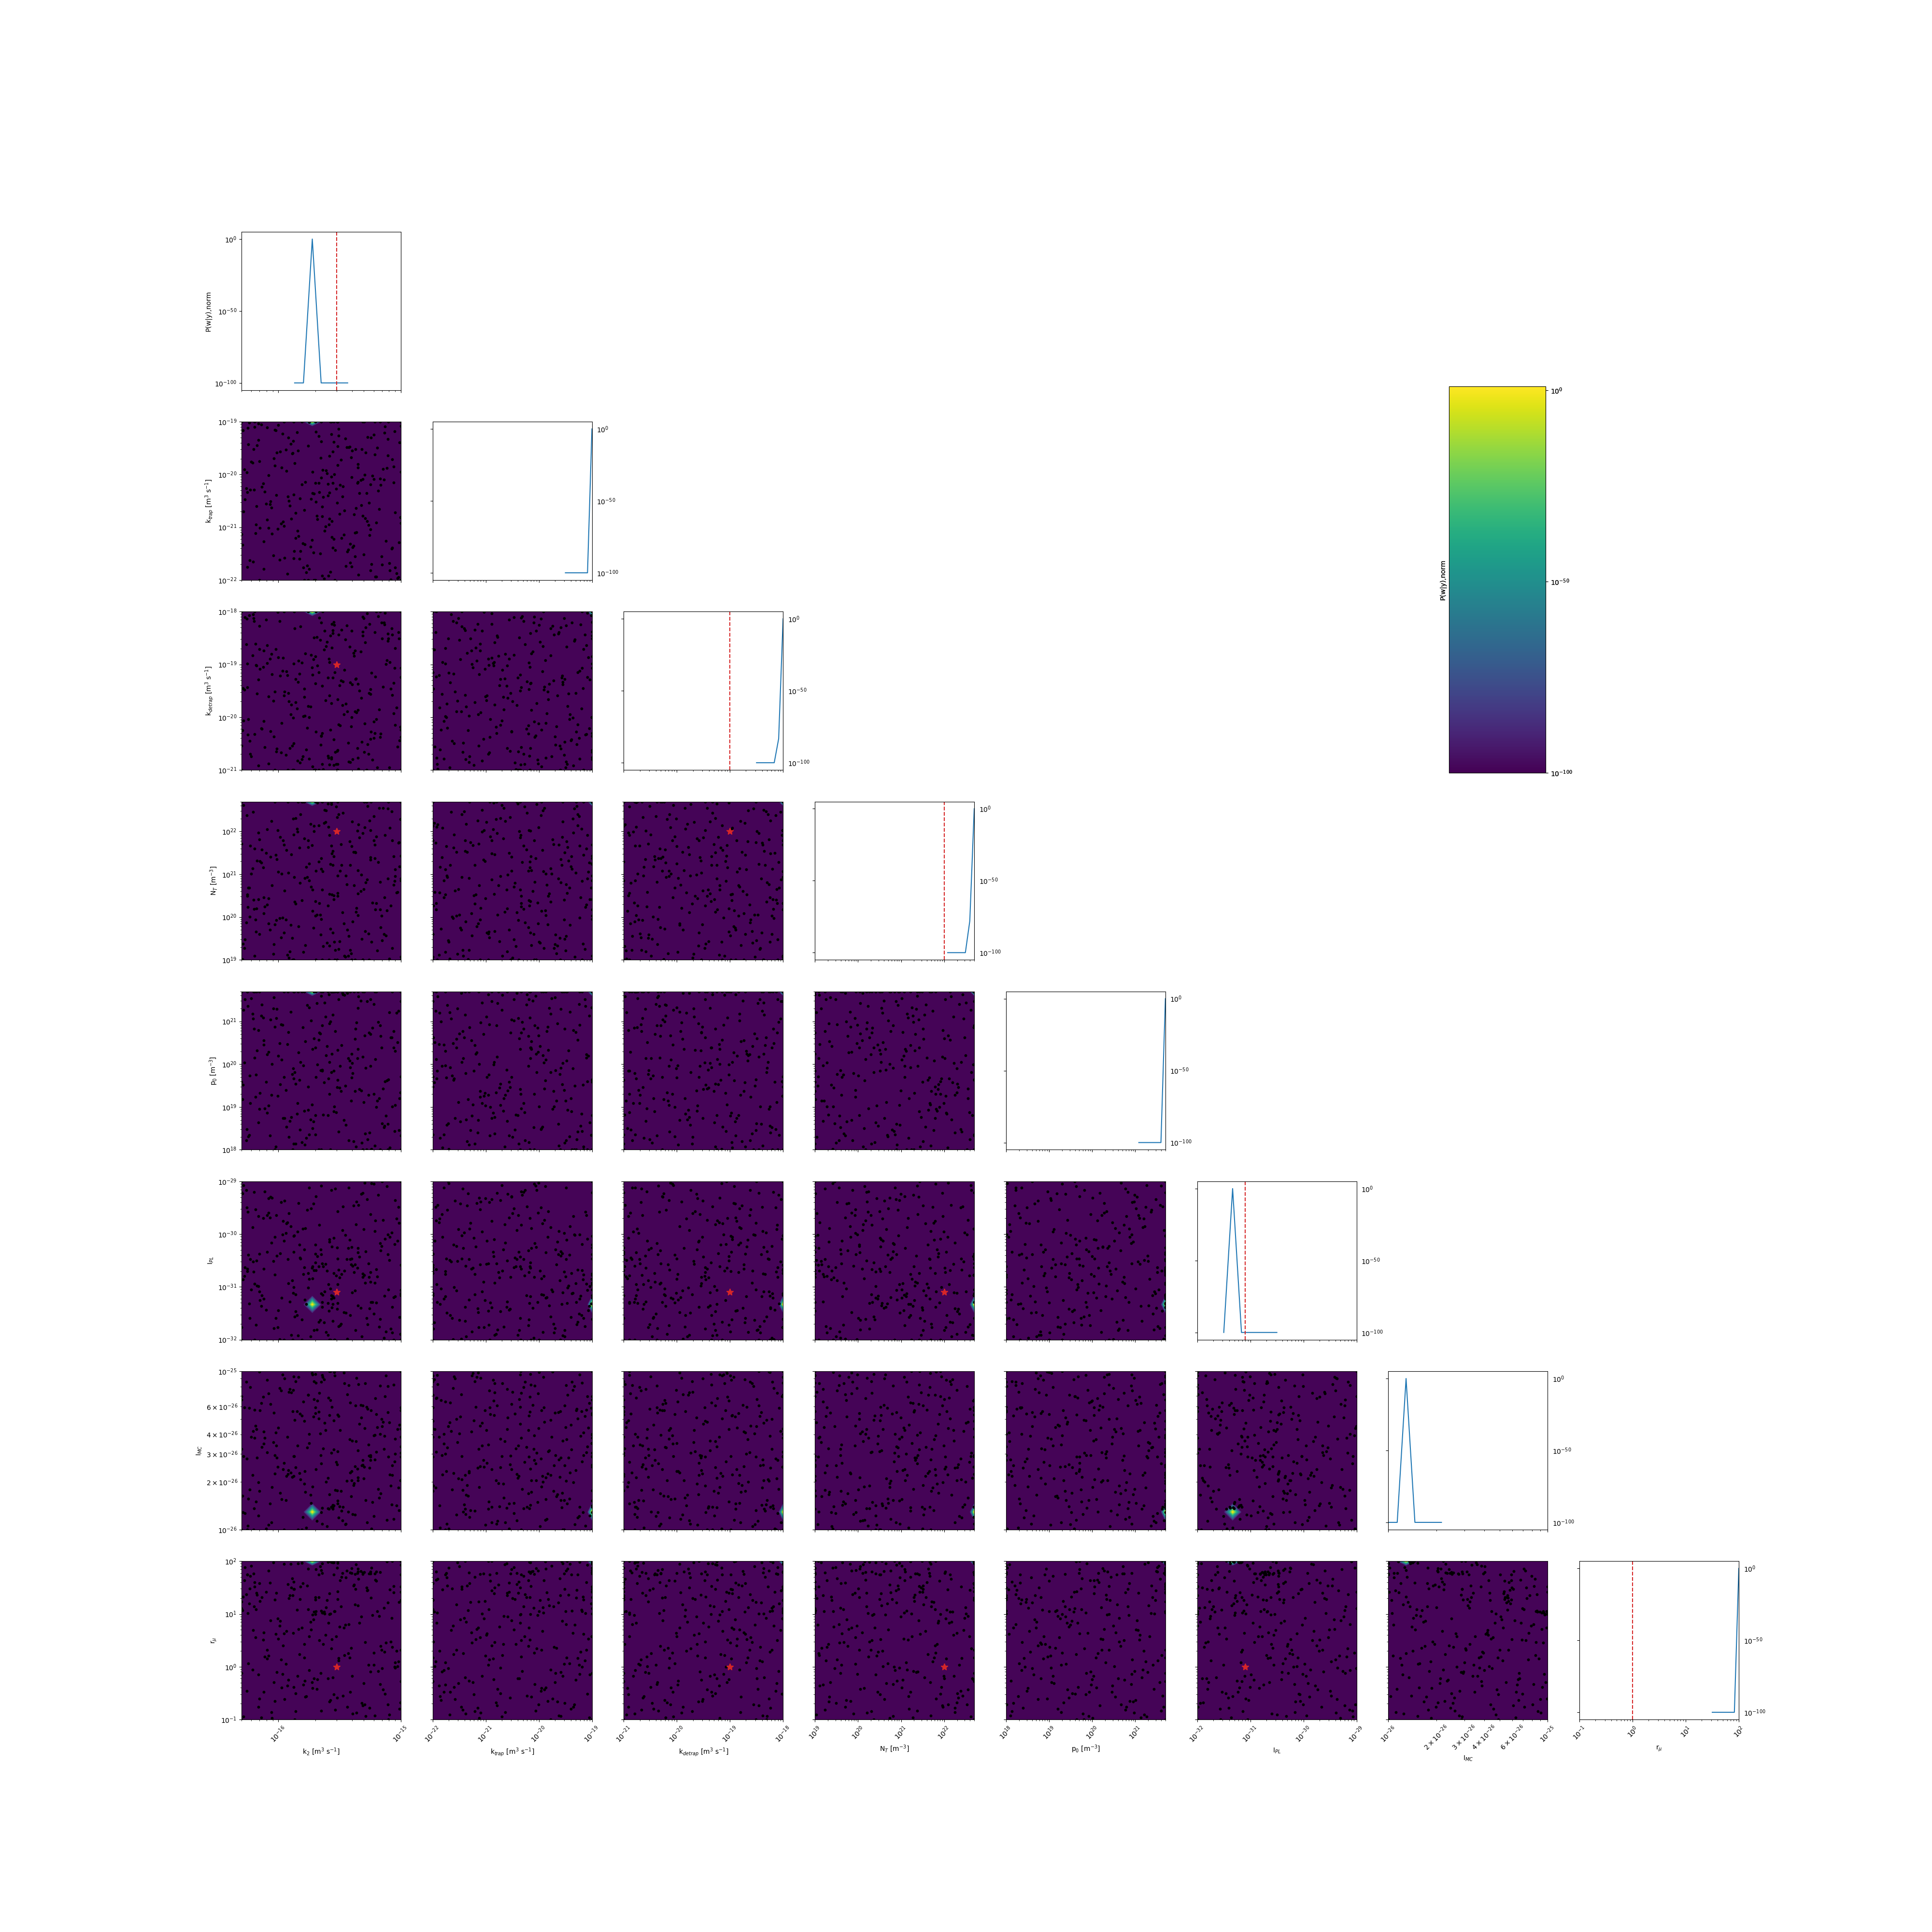

In [7]:
# start multiobjective optimization
# X_dimensions = ['t','N0']
X_dimensions = ['t','Gfrac']
y_dimension = 'PL [a.u.]'
target = {'model':partial(trPL.trPL,X_dimensions=X_dimensions,take_log=False),'target_name':'trPL',
          'data':{'X':X_PL,'y':y_PL,'X_dimensions':X_dimensions,'X_units':['s','m$^{-3}$'],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}
y_dimension = '$\sigma$ [a.u.]'
target2 = {'model':partial(trMC.trMC,X_dimensions=X_dimensions,take_log=False),'target_name':'trMC',
           'data':{'X':X_MC,'y':y_MC,'X_dimensions':X_dimensions,'X_units':['s','m$^{-3}$'],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

targets = [target,target2]
mo = MultiObjectiveOptimizer(params=params, targets = targets)

n_jobs = 4 # was 4
n_jobs_init = 40 # was 4
n_yscale=20 # was 20
n_BO = 80 # was 60
n_initial_points = 200 # was 200
n_BO_warmstart = 20 # was 5

mo.warmstart = 'None'
kwargs = {'check_improvement':'relax','max_loop_no_improvement':40,'xtol':1e-3,'ftol':1e-3}#,'acq_func':'LCB','acq_func_kwargs' : {"xi": 0.000001, "kappa": 0.001}}
kwargs_posterior = {'Nres':7,'gaussfilt':1,'logscale':True,'vmin':1e-100,'zoom':2,'min_prob':1e-40,'clear_axis':False,'show_points':True,'savefig':True,'figname':'param_posterior','True_values':True_values}
kwargs_plot_obj = {'zscale':'linear'}

r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_BO_warmstart=n_BO_warmstart,n_jobs_init=n_jobs_init,kwargs=kwargs,verbose=False,loss='linear',threshold=1000,base_estimator = 'GP',show_objective_func=False,show_posterior=True,kwargs_posterior = kwargs_posterior,kwargs_plot_obj=kwargs_plot_obj)
    


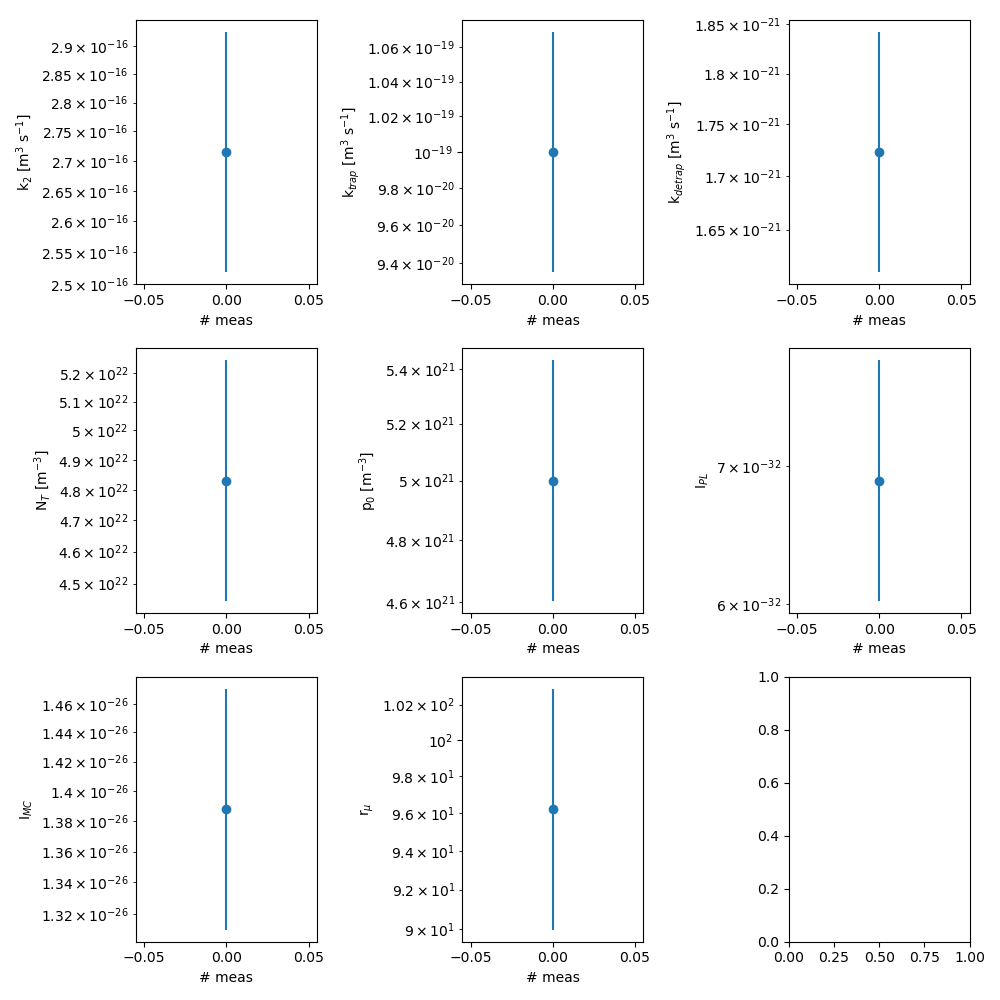

In [8]:

info= trPL.plot_params([mo.params],fpu=[],kwargs={'nrows':3,'ncols':3,'figsize':(10,10),'figname':os.path.join(res_dir,'fit_params')})


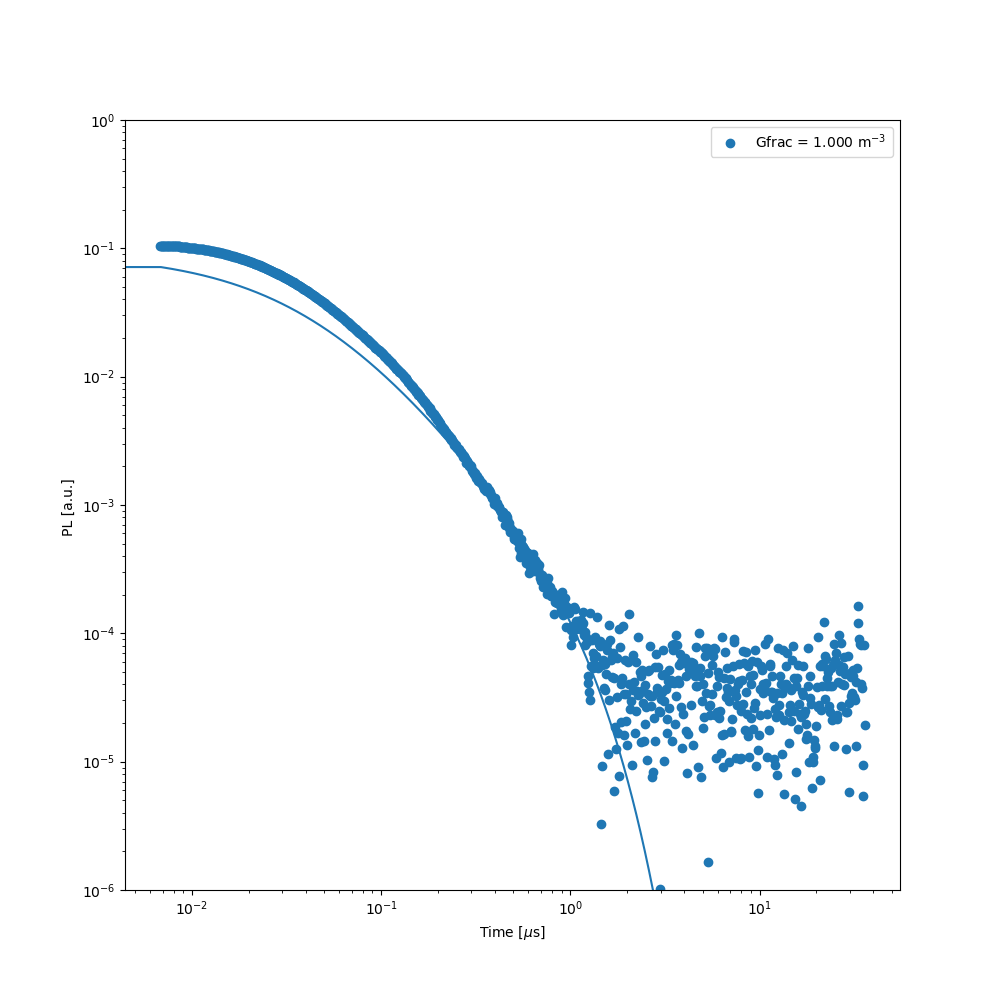

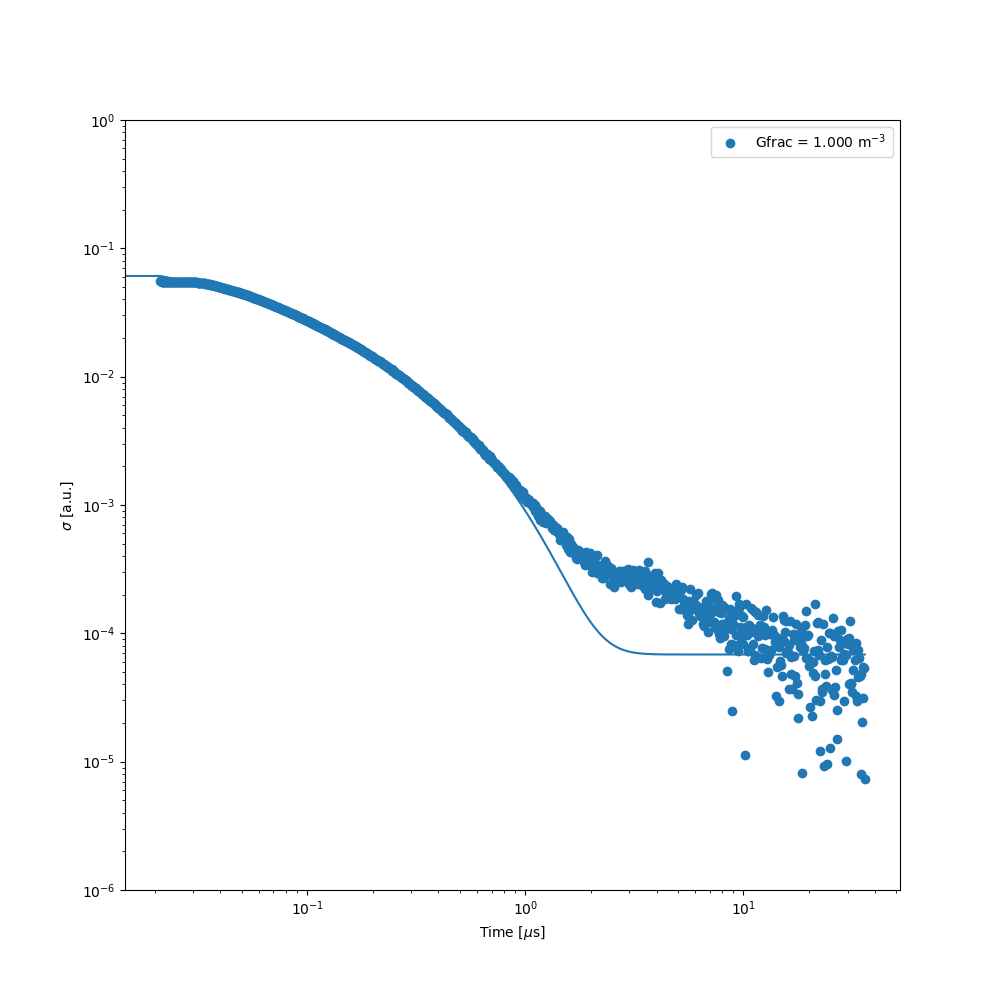

In [14]:
# Plot and save the results
fit_results = []
kwargs_plot_res = {'x_scaling':1e6,'xaxis_label':'Time [$\mu$s]','xscale_type':'log','yscale_type':'log','norm_data':False,'delog':False,'figsize':(10,10)}

for num,t in enumerate(targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    trPL.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[1e-6,1],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = trPL.get_param_dict(mo.params) # get fitparameters (and fixed ones)

pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]


# produce output excel file with data, fitparameters and FOMs
fn_xlsx = 'fits_results.xlsx'
namecols = X_dimensions + ['Jexp','Jfit']
# delete old file if it exists
if os.path.exists(os.path.join(res_dir,fn_xlsx)):
    os.remove(os.path.join(res_dir,fn_xlsx))

with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
    for i,t in enumerate(targets):
        if 'target_name' in t.keys():
            tname = t['target_name']
        else: 
            tname = 'data'
        namecols = X_dimensions + [tname+'_exp',tname+'_fit']
        df = pd.DataFrame(fit_results[i],columns=namecols)
        df.to_excel(writer, sheet_name = tname+f'_{i}')
       
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = f'params')

In [10]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *
Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    # delete old_xy.json file if it exists
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'temp/')):
        shutil.rmtree(os.path.join(os.getcwd(),'temp/'))
